# Configuration

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Anime Recommendations") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()
show = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets

In this session, we will use two dataset files.
- Pre-processed rating dataset ("unified_dataset_prep.csv"): Main pre-processed file ready to feed into ALS model for predictions.
- Anime dataset ("anime-dataset-2023.csv"): To retrieve anime title information for trend analysis and recommendation list.

We shall not perform any data pre-processing in this section. The whole process had been done in "data_processing.ipynb".

In [ ]:
data_dir = "/content/drive/MyDrive/stuff/"

rating_df = spark.read.csv(data_dir + "unified_dataset_prep.csv", header=True, inferSchema=True)
anime_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(data_dir + "anime-dataset-2023.csv", header=True, inferSchema=True)

In [ ]:
rating_df.show()

+-------+--------+--------------------+
|user_id|anime_id|              rating|
+-------+--------+--------------------+
|   20.0|  1519.0|-1.64490933078227...|
|   20.0|   121.0|-1.52855701246282...|
|   20.0|  5365.0|-1.71549663906513...|
|   23.0|  5355.0|-1.75634330051323...|
|   70.0|  3594.0|-1.76278776793842...|
|   80.0|   121.0|-1.52855701244992...|
|  120.0|   132.0|-1.48323035626425...|
|  120.0|    43.0|-1.154905572128283E9|
|  138.0|  4415.0|-1.724022761985409E9|
|  185.0|   403.0|-1.40065877654874...|
|  208.0|    17.0|-1.481148700787817E9|
|  212.0|  2963.0|-1.690543696497511E9|
|  222.0|  2717.0|-1.65110942548475...|
|  222.0|  4151.0|-1.72986078472963...|
|  255.0|   268.0|-1.16710677685679...|
|  255.0|    20.0|-1.55828332539736...|
|  282.0|  1454.0|-1.63867333874731...|
|  282.0|  6201.0|-1.76795100569715...|
|  300.0|   257.0|-1.50347636355938...|
|  341.0|    85.0|-6.984861493964928E8|
+-------+--------+--------------------+
only showing top 20 rows



In [ ]:
anime_df.show()

+--------+--------------------+--------------------+------------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----------+-------------+--------------------+------+----------+---------+---------+-------+--------------------+
|anime_id|                Name|        English name|                    Other name|Score|              Genres|            Synopsis| Type|Episodes|               Aired|  Premiered|          Status|           Producers|           Licensors|         Studios|     Source|     Duration|              Rating|  Rank|Popularity|Favorites|Scored By|Members|           Image URL|
+--------+--------------------+--------------------+------------------------------+-----+--------------------+--------------------+-----+--------+--------------------+-----------+----------------+--------------------+--------------------+----------------+-----

It has to be noted that the dataset is only used to retrieve anime title information (anime_id, name, synopsis, genres) for trend analysis and recommendation list.

So we simply crop those columns.

In [ ]:
from pyspark.sql.functions import col
anime_df = anime_df.select('anime_id', 'Name', 'Genres', 'Synopsis')\
  .withColumn("anime_id", col("anime_id").cast(IntegerType()))
anime_df.persist()

DataFrame[anime_id: int, Name: string, Genres: string, Synopsis: string]

# ALS model

## Model

Dataset splitting

In [ ]:
# Split into train, test and validation set (70-5-25 split)
train_df, val_df, test_df = rating_df.randomSplit([0.7, 0.05, 0.25], seed=42)

In [ ]:
print(f"Train count: {train_df.count()}")
print(f"Validation count: {val_df.count()}")
print(f"Test count: {test_df.count()}")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

train_ratings = train_df.select('rating').toPandas()
val_ratings = val_df.select('rating').toPandas()
test_ratings = test_df.select('rating').toPandas()

plt.figure(figsize=(15, 5))

sns.kdeplot(train_ratings['rating'], label='Train', fill=True)
sns.kdeplot(val_ratings['rating'], label='Validation', fill=True)
sns.kdeplot(test_ratings['rating'], label='Test', fill=True)

plt.title('Rating Distribution Across Splits')
plt.legend()
plt.show()

In [ ]:
train_users = train_df.select('user_id').distinct()
val_users = val_df.select('user_id').distinct()
test_users = test_df.select('user_id').distinct()

print("Train Users:", train_users.count())
print("Validation Users:", val_users.count())
print("Test Users:", test_users.count())

train_items = train_df.select('item_id').distinct()
val_items = val_df.select('item_id').distinct()
test_items = test_df.select('item_id').distinct()

print("Train Items:", train_items.count())
print("Validation Items:", val_items.count())
print("Test Items:", test_items.count())

Model configuration and training

# Comparative Analysis of Recommender System Algorithms

| Algorithm | Strengths | Weaknesses | Scalability | Cold Start Handling | Implementation Complexity | Best Use Cases |
|-----------|-----------|------------|-------------|---------------------|--------------------------|----------------|
| **ALS (Alternating Least Squares)** | - Highly scalable with parallel computation<br>- Good with implicit feedback<br>- Handles sparse matrices efficiently<br>- Built-in regularization | - Black box interpretability<br>- Requires tuning multiple hyperparameters<br>- Needs relatively large datasets for best performance | Excellent (Spark implementation scales to millions of users) | Moderate (handles new users better than new items) | Moderate (Spark provides strong implementation) | - Large-scale production systems<br>- Implicit feedback datasets<br>- When computational efficiency matters |
| **User-User Collaborative Filtering** | - Intuitive approach<br>- Simple to implement and explain<br>- Works well with dense data<br>- No training phase needed | - Poor scalability<br>- Real-time predictions slow<br>- "Popularity bias" problem | Poor (computation increases with user base) | Good for new items, poor for new users | Low (straightforward implementation) | - Small to medium datasets<br>- When interpretability matters<br>- Frequently changing item catalogs |
| **Item-Item Collaborative Filtering** | - More stable than user-user<br>- Can be precomputed<br>- Better for sparse user data<br>- Good interpretability | - Memory intensive<br>- Limited by available item attributes<br>- Less personalized than user-based | Moderate (item set usually smaller than user set) | Good for new users, poor for new items | Low (simple implementation) | - E-commerce recommendations<br>- When "customers who bought X also bought Y"<br>- Stable item catalogs |
| **Content-Based Filtering** | - No cold start problem for items<br>- Highly interpretable recommendations<br>- Independent of other users | - Requires rich item metadata<br>- Overspecialization/lack of diversity<br>- Limited by available features | Good (scales with features, not users) | Excellent for new items | Moderate (depends on feature engineering) | - Specialized domains (movies, articles)<br>- New items need immediate recommendations<br>- When user privacy is important |

In this implementation, we decided to use ALS for this project due to easier scalability and suitability with large-scale production systems, as well as computational efficiency

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="user_id",
    itemCol="anime_id",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True
)

# Train on training set
model = als.fit(train_df)

# Validate on validation set
val_predictions = model.transform(val_df)

Training evaluation

In [ ]:
# Evaluate using RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="rating",
    predictionCol="prediction"
)
val_rmse = evaluator.evaluate(val_predictions)
print(f"Validation RMSE: {val_rmse}")

# Final evaluation on test set (after model selection if you're tuning)
test_predictions = model.transform(test_df)
test_rmse = evaluator.evaluate(test_predictions)
print(f"Test RMSE: {test_rmse}")

Validation RMSE: 1.2582881903305252
Test RMSE: 1.2571983779688873


Model saving

In [ ]:
# Save the ALS model
model_path = "/content/drive/MyDrive/stuff/als_model"  # Replace with your desired path
model.write().overwrite().save(model_path)

print(f"ALS model saved to: {model_path}")

ALS model saved to: /content/drive/MyDrive/stuff/als_model


## Deploy

### Configurations

In [ ]:
import random
def generateNewID(dataFrame):
    existing_id_list = dataFrame.select("user_id").distinct().rdd.map(lambda x: x[0]).collect()
    mx = max(existing_id_list)
    a = existing_id_list[0]
    while a in existing_id_list:
        a = random.randint(1, mx*2)
    return a

In [ ]:
from pyspark.sql.functions import lit, col
from pyspark.ml.recommendation import ALSModel
from pyspark.sql.types import StructType, StructField, IntegerType
dataset_dir = "drive/MyDrive/stuff/"
anime_dataset_path = dataset_dir + "anime-dataset-2023_prep.csv"
user_input_path = dataset_dir + "myRating.csv"
model_dir = dataset_dir + "als_model"
rating_dataset_path = dataset_dir + "users-score-2023_prep.csv"

model = ALSModel.load(model_dir)

Only run this code when the data frames are not loaded, yet.

In [ ]:
# rating_df = spark.read.csv(rating_dataset_path, header=True, inferSchema=True)\
#     .withColumn("rating", col("rating").cast(IntegerType()))\
#     .select("user_id", "anime_id", "rating")
# anime_df = spark.read\
#     .option("header", True)\
#     .option("escape", '"')\
#     .option("multiline", True)\
#     .option("sep", ",")\
#     .csv(anime_dataset_path, header=True)\
#     .select("anime_id", "Name", "Genres", "Synopsis")

### Recommendation

In [ ]:
# Generate recommendations for all users
#recommendations = model.transform(rating_df)
recommendations = model.recommendForAllUsers(20)

In [ ]:
from pyspark.sql.functions import explode, col, broadcast

watched_anime = rating_df.select("user_id", "anime_id")

exploded_recommendations = recommendations.select(
    "user_id",
    explode("recommendations").alias("rec")
).select(
    "user_id",
    col("rec.anime_id").alias("anime_id"),
    col("rec.rating").alias("prediction")
)

# Join with anime_df to get details
recommendations_with_details = exploded_recommendations.join(
    broadcast(anime_df),
    "anime_id"
).select(
    "user_id", "anime_id", "Name", "Genres", "Synopsis", "prediction"
)

# Filter out already watched anime
final_recommendations = recommendations_with_details.join(
    broadcast(watched_anime),
    on=["user_id", "anime_id"],
    how="left_anti"
)

Here, since the results are big, forcing the final_recommendations to cache for visualization to run faster

In [ ]:
final_recommendations.cache()
final_recommendations.count()

5215204

In [ ]:
from pyspark.sql.functions import col
# Sort recommendations by prediction score
final_recommendations = recommendations_with_details \
    .orderBy(col("prediction").desc())

In [ ]:
# Show top recommendations
if show:
  final_recommendations.show()

+-------+--------+-------------+--------------+--------------------+----------+
|user_id|anime_id|         Name|        Genres|            Synopsis|prediction|
+-------+--------+-------------+--------------+--------------------+----------+
| 604339|    9906|      Sue Cat|     Adventure|After an accident...| 39.715103|
| 329584|    9906|      Sue Cat|     Adventure|After an accident...| 37.104156|
| 313027|    9906|      Sue Cat|     Adventure|After an accident...| 36.107742|
| 543765|    9906|      Sue Cat|     Adventure|After an accident...| 35.388515|
| 982571|    9906|      Sue Cat|     Adventure|After an accident...|  35.15631|
| 521843|    9906|      Sue Cat|     Adventure|After an accident...| 35.067898|
|   8350|    9906|      Sue Cat|     Adventure|After an accident...| 34.494415|
| 312244|    9906|      Sue Cat|     Adventure|After an accident...| 34.475872|
|1200121|   32237|Burutabu-chan|Comedy,Fantasy|Burutabu-chan is ...| 34.203545|
| 432623|    9906|      Sue Cat|     Adv

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud

User-Specific Recommendation Dashboard


In [ ]:
# Convert to Pandas DataFrame for visualization
def visualize_user_recommendations(user_id):
    #user_recs = recommendations_pd[recommendations_pd['user_id'] == user_id].head(10)
    user_recs = final_recommendations.filter(col("user_id") == user_id) \
                                    .to_pandas_on_spark()

    # Create figure
    plt.figure(figsize=(15, 10))

    # Top recommended anime
    plt.subplot(2, 2, 1)
    sns.barplot(x='prediction', y='Name', data=user_recs)
    plt.title(f'Top Recommendations for User {user_id}')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Anime Title')

    # Genre distribution
    plt.subplot(2, 2, 2)
    genres = user_recs['Genres'].str.split(',', expand=True).stack()
    genres.value_counts().head(10).plot(kind='bar')
    plt.title('Recommended Genre Distribution')
    plt.xticks(rotation=45)

    # Rating distribution
    plt.subplot(2, 2, 3)
    sns.histplot(user_recs['prediction'], bins=10, kde=True)
    plt.title('Predicted Rating Distribution')
    plt.xlabel('Predicted Rating')

    # Word cloud of synopsis
    plt.subplot(2, 2, 4)
    text = ' '.join(user_recs['Synopsis'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Common Themes in Recommendations')

    plt.tight_layout()
    plt.show()

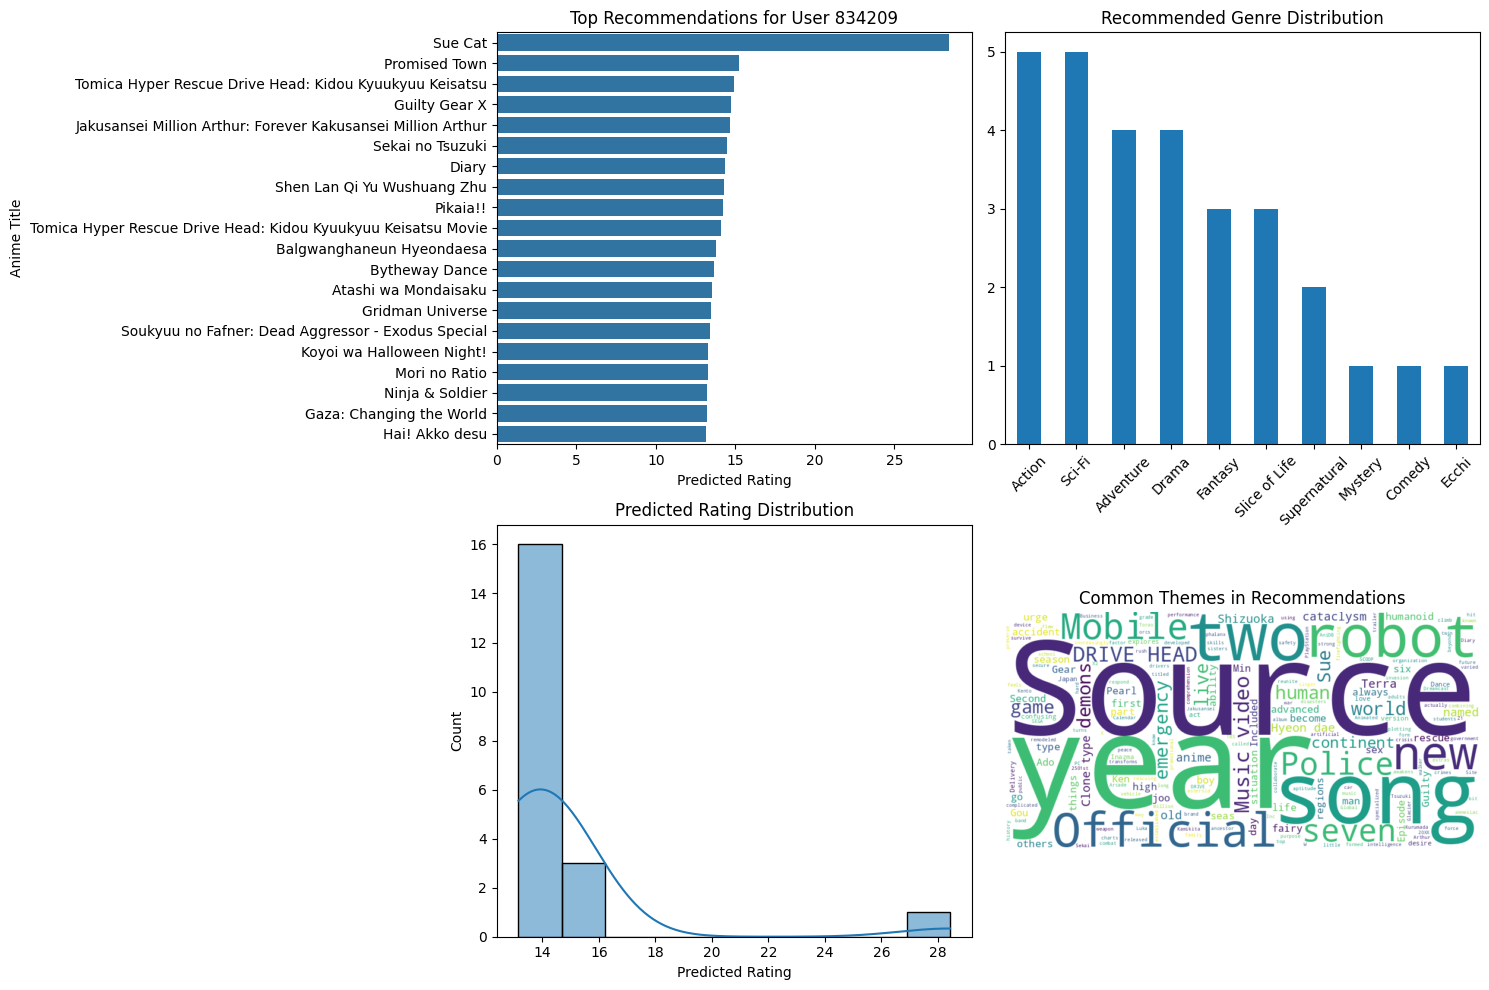

In [ ]:
# Example usage
visualize_user_recommendations(user_id=834209)  # replace with actual user ID

Here are the insights from the user dashboard for User 834209 based on the visualizations:

---

### **Top Recommendations**
- **Highest rated recommendation:** *Sue Cat* stands out with a **significantly higher predicted rating (~28)** than all others.
- **Most recommended titles (top 5):**
  - *Sue Cat*
  - *Promised Town*
  - *Tomica Hyper Rescue Drive Head: Kidou Kyuukyuu Keisatsu*
  - *Guilty Gear X*
  - *Jakusansei Million Arthur*

These are the anime titles the system predicts the user would probably most enjoy.

---

### **Recommended Genre Distribution**
- **Dominant genres:**
  - **Action** and **Sci-Fi** are the most recommended genres (5 animes each).
  - Followed by **Adventure**, **Drama**, and **Fantasy** (4 animes each).
- **Least recommended genres:**
  - **Comedy**, **Mystery**, and **Ecchi** have the fewest recommendations (1 anime each).

This suggests the user’s preferences are skewed towards action-packed, futuristic, and emotionally engaging genres.

---

### **Predicted Rating Distribution**
- **Rating range:** Most recommendations cluster between **13 and 16** predicted rating.
- **Outlier:** *Sue Cat* is a clear outlier with a rating close to **28**, suggesting it's highly aligned with the user’s preferences.

The skewed distribution implies that while most recommendations are good, a few are predicted to be excellent.

---

### **Common Themes (Word Cloud)**
- **Frequent keywords:** “source,” “year,” “song,” “two,” “robot,” “Mobile,” “Police,” “Official”
- **Thematic lean:** Themes related to **technology**, **music**, and **law enforcement** dominate the recommendations.

These recurring themes indicate potential strong interest areas for the user—possibly in mecha, police dramas, or music-oriented anime.

---

### **Overall Summary**
User 834209 has strong affinities for:
- High-action, Sci-Fi, and adventure anime
- Narratives involving robots, law enforcement, and possibly musical elements
- A standout preference predicted for *Sue Cat*, which might be worth prioritizing in recommendations or promotions

In [ ]:
if show:
  final_recommendations.show()

+-------+--------+-------------+--------------+--------------------+----------+
|user_id|anime_id|         Name|        Genres|            Synopsis|prediction|
+-------+--------+-------------+--------------+--------------------+----------+
| 604339|    9906|      Sue Cat|     Adventure|After an accident...| 39.715103|
| 329584|    9906|      Sue Cat|     Adventure|After an accident...| 37.104156|
| 313027|    9906|      Sue Cat|     Adventure|After an accident...| 36.107742|
| 543765|    9906|      Sue Cat|     Adventure|After an accident...| 35.388515|
| 982571|    9906|      Sue Cat|     Adventure|After an accident...|  35.15631|
| 521843|    9906|      Sue Cat|     Adventure|After an accident...| 35.067898|
|   8350|    9906|      Sue Cat|     Adventure|After an accident...| 34.494415|
| 312244|    9906|      Sue Cat|     Adventure|After an accident...| 34.475872|
|1200121|   32237|Burutabu-chan|Comedy,Fantasy|Burutabu-chan is ...| 34.203545|
| 432623|    9906|      Sue Cat|     Adv

Genre Popularity Across Recommendations

In [ ]:
def visualize_recommendation_distribution():
    # Get prediction distribution
    pred_dist = final_recommendations.select("prediction").to_pandas_on_spark()

    # Create a histogram of the predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(pred_dist['prediction'], bins=20, kde=True)
    plt.title('Distribution of Predicted Ratings')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Count')
    plt.show()

In [ ]:
visualize_recommendation_distribution()

This chart shows the **overall distribution of predicted ratings** for all user-item pairs in the recommendation system, providing a macro view of the model's rating behavior. Here's the insight:

---

### **Overall Predicted Rating Distribution**
- **Bell-shaped, right-skewed distribution**: The bulk of predicted ratings fall between **8 and 12**, with a **sharp peak around 10**.
- **Long tail**: A smaller number of ratings extend all the way up to ~38, but these are rare.
- **Most common range**: Between **9 and 11**, suggesting the model tends to predict ratings in this range for the majority of items.

---

### Implications
- **Sue Cat's predicted rating (~28)** for user 834209 is extremely rare and statistically significant, considering the global distribution.
- The recommendation model is **conservative**, predicting high ratings only when it has high confidence.
- The long right tail shows that **outlier items** with very high predicted appeal are present but **very few**.

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


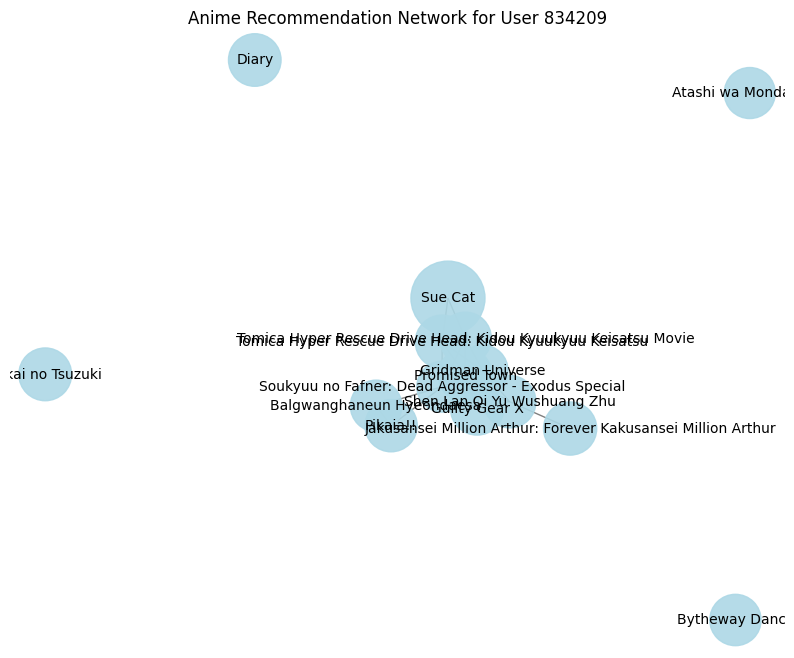

In [ ]:
import networkx as nx

def visualize_anime_network(user_id, top_n=15):
    user_recs = final_recommendations.filter(col("user_id") == user_id) \
                                    .limit(top_n).to_pandas_on_spark()

    G = nx.Graph()

    # Add nodes (anime)
    for _, row in user_recs.iterrows():
        G.add_node(row['Name'],
                  genres=row['Genres'],
                  rating=row['prediction'])

    # Add edges based on shared genres
    for i, row1 in user_recs.iterrows():
        genres1 = set([])
        if row1['Genres'] is not None:
            genres1 = set(row1['Genres'].split(','))
        for j, row2 in user_recs.iterrows():
            if i >= j:
                continue
            genres2 = set([])
            if row2['Genres'] is not None:
                genres2 = set(row2['Genres'].split(','))
            shared = genres1.intersection(genres2)
            if shared:
                G.add_edge(row1['Name'], row2['Name'],
                          weight=len(shared),
                          genres=",".join(shared))

    # Draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G)

    # Node size by predicted rating
    node_sizes = [G.nodes[n]['rating']*100 for n in G.nodes()]

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes,
                          node_color='lightblue', alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10)

    plt.title(f'Anime Recommendation Network for User {user_id}')
    plt.axis('off')
    plt.show()

# Example usage
visualize_anime_network(user_id=834209)

This visualization shows a **recommendation network graph** for User 834209, illustrating how anime recommendations are clustered or connected. Here are the insights:

---

### **Recommendation Network Insights**
- **Sue Cat** is the **central node**, indicating it has the **strongest predicted affinity** (most highly rated recommendation) and is **well-connected** to other suggested titles.
- **Clustered connections**:
  - Several anime titles are **closely grouped**, indicating they might share **genres, themes, or user interaction patterns**.
  - Examples: *Tomica Hyper Rescue Drive Head*, *Gridman Universe*, *Soukyuu no Fafner*, *Pikaia!!*, and others form a dense core cluster.
- **Peripheral nodes**: Titles like *Diary*, *Atashi wa Mondaisaku*, *Seka no Tsuzuki*, and *Bytheway Dance* are more **isolated**, potentially suggesting:
  - **Unique themes** not shared with others.
  - **Exploratory recommendations** based on user novelty preferences or cold-start items.

---

### Implications
- This user may have a **clear favorite** (Sue Cat), which may influence similar recommendations.
- The network shows a blend of **core, theme-based suggestions** and **peripheral, novel recommendations**, indicating a **balanced approach** between relevance and discovery.
- Could be used to **enhance explainability** in recommendations—“You might like *Gridman Universe* because it’s similar to *Sue Cat*.”
---